In [ ]:
import sys
!{sys.executable} -m pip install beautifulsoup4 lxml html5lib

In [ ]:
import csv
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
import time

headers = {
    'accept': '*/*',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.9',
    'referer': 'https://www.google.com',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.83 Safari/537.36 Edg/85.0.564.44'
}

def get_article(card):
    """Extract article information from the raw html"""
    raw_link = card.get('href')
    response = requests.get(raw_link, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    article_body = soup.find('div', 'article_body')
    if article_body:
        article_body = soup.find('div', 'article_body').text.replace('\n', ' ').strip()
        return [article_body]

def get_the_news(url):
    """Run the main program"""
    driver = webdriver.Chrome('./chromedriver') 
    driver.get(url) 
    time.sleep(5) 
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    cards = soup.find_all('a', 'newsFeed_item_link')
    # extract articles from page
    articles = []
    for card in cards[:50]:
        article = get_article(card)
        articles.append(article)
        with open('news.csv', 'a', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerows(articles)
        articles = []  
     

# run the main program
get_the_news('https://news.yahoo.co.jp/categories/business')
get_the_news('https://news.yahoo.co.jp/categories/sports')
get_the_news('https://news.yahoo.co.jp/categories/it')
get_the_news('https://news.yahoo.co.jp/categories/science')


In [1]:
import jieba

with open('news.csv') as f:
    japanese_text = f.read()
    japanese_text = japanese_text.split()
print(len(japanese_text))
texts = []
for sentence in japanese_text:
    texts.append(jieba.cut(sentence))
texts = [[word for word in text if len(word)>1] for text in texts]
with open('thesaurus.txt', 'w') as filehandle:
    for listitem in texts:
        filehandle.write("\n".join(map(lambda x: str(x), listitem)))

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache


2355


Loading model cost 0.501 seconds.
Prefix dict has been built successfully.


In [2]:
def is_number(n):
    is_number = True
    try:
        #      v type-casting the number here as `complex`, instead of `float`
        num = complex(n)
        is_number = num == num
    except ValueError:
        is_number = False
    return is_number

def is_english(s):
  return s.isascii()

with open('thesaurus.txt', 'r') as f:
    words = [line.rstrip('\n') for line in f]

print(len(words))

import re
words = [re.sub("[a-zA-Z0-9…！？「」。，、：“”《》；— —（）\s+ ]", '', _) for _ in words]

for w in words:
    if is_number(w) or is_english(w):
        words.remove(w)
print(len(words))

10524
9174


In [3]:
from collections import Counter

def create_lookup_tables(words):
    """
    Create lookup tables for vocabulary
    :param words: Input list of words
    :return: Two dictionaries, vocab_to_int, int_to_vocab
    """
    word_counts = Counter(words)
    # sorting the words from most to least frequent in text occurrence
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    # create int_to_vocab dictionaries
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab

# words = preprocess(text)
vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]
# print some stats about this word data
print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words)))) # `set` removes any duplicate words

Total words in text: 9174
Unique words: 3407


In [4]:
from collections import Counter
import random
import numpy as np

threshold = 1e-5
word_counts = Counter(int_words)
#print(list(word_counts.items())[0])  # dictionary of int_words, how many times they appear

total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
# discard some frequent words, according to the subsampling equation
# create a new list of words for training
# train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]
train_words = [word for word in int_words if word_counts[word] > threshold]
print(len(train_words))
print(train_words[:30])


9174
[111, 81, 544, 81, 1289, 1290, 545, 420, 794, 152, 546, 111, 7, 179, 81, 111, 6, 1291, 7, 1292, 220, 153, 421, 12, 12, 12, 12, 12, 12, 12]


In [5]:

def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = words[start:idx] + words[idx+1:stop+1]
    
    return list(target_words)

In [6]:
# run this cell multiple times to check for random window selection
int_text = [i for i in range(10)]
print('Input: ', int_text)
idx=5 # word index of interest

target = get_target(int_text, idx=idx, window_size=5)
print('Target: ', target)  # you should get some indices around the idx

Input:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Target:  [2, 3, 4, 6, 7, 8]


In [7]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    n_batches = len(words)//batch_size
    # only full batches
    words = words[:n_batches*batch_size]
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

In [8]:
int_text = [i for i in range(20)]
x,y = next(get_batches(int_text, batch_size=4, window_size=5))

print('x\n', x)
print('y\n', y)

x
 [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3]
y
 [1, 2, 3, 0, 2, 3, 0, 1, 3, 1, 2]


In [9]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
        
    return valid_examples, similarities

In [10]:
import torch
from torch import nn
import torch.optim as optim

In [11]:
class SkipGram(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()
        
        self.embed = nn.Embedding(n_vocab, n_embed)
        self.output = nn.Linear(n_embed, n_vocab)
        self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.embed(x)
        scores = self.output(x)
        log_ps = self.log_softmax(scores)
        
        return log_ps

In [32]:
# check if GPU is available
CUDA_LAUNCH_BLOCKING=1.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

embedding_dim=300 # you can change, if you want

model = SkipGram(len(vocab_to_int), embedding_dim).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 500
steps = 0
epochs = 100

# train for some number of epochs
for e in range(epochs):
    
    # get input and target batches
    for inputs, targets in get_batches(train_words, 500):
        steps += 1
        inputs, targets = torch.LongTensor(inputs), torch.LongTensor(targets)
        inputs, targets = inputs.to(device), targets.to(device)
        
        log_ps = model(inputs)
        loss = criterion(log_ps, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if steps % print_every == 0:                  
            # getting examples and similarities      
            valid_examples, valid_similarities = cosine_similarity(model.embed, device=device)
            _, closest_idxs = valid_similarities.topk(6) # topk highest similarities
            
            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...")

集部 | 相当, 礼儀, 業場, 車券, 立役契約
東京 | 水準, 棟数, 入庫京都, 調整飲食店, 失策
購入 | 業場, 挽回, 高久, 春馬, 沈没
最大 | 充填, 方向電子, 音声, 保全, 改善名古屋
安打 | 業員向, 右前, 素振木村, 仕切, 年培
代表 | 目標, 感動, 階建, 威勢, 山本
公式 | 結果, 無償, 語音, 遜色, 識別
日本 | 流暢, 集中力, 驚異, 松岡大起, 開橋新外
選出 | 苦笑英語大谷, 指名, 年時, 前日桑原, 前週
天心 | 一刻, 漏洩, 台分, 宮崎, 立浪
黄金 | 人感, 配信惑星見放題, 受賞, 大会, 高鳴
強豪 | 誹謗, 直前参考, 末尾, 季初, 映像写真
西村 | 合成, 展開場面, 打率, 優菜, 共同
部員 | 船首, 主演, 西武, 法律, 建国構成
頑張 | 出来人前, 利用., 集計, 通信量今春, 熱投
主将 | 反面口言, 達成独立, 新聞社一投手, 赤澤, 翔平米国
...
業員 | 配属, 入社, 造化, 室内, 国際化
記事 | 機材, 出現, 利用画像, 商材, 名付
場所 | 外出, 何度, 特長, 中核, 航地
番号 | 負担電話機, 競技会場, 腎炎食品, 利用, 通話料
配信 | 原作者, 配信独占, 番組, 美紀氏, 一例
撮影 | 設計予約, 心頭選手, 独身, 全力, 十分
金額 | 技術, 作成, 破綻, 割強, 西川
移行 | 代理店, 形一見, 端末, 予定洋画見放題, 薄型
頑張 | 出来人前, 熱投, 利用., 通信量今春, 集計
進化 | 業開始, 破棄, 送信, 業種, 天心
秘密 | 女性同紙, 日程, 表情, 一理, 日明
指名 | 冒頭, 選出, 洋服, 大谷大谷, 打者
同一 | 化球全体, 場合, 世界世界全部口言全部大丈夫世界, 意義, 話題
年交際 | 結婚写真, 意志十字, 貢献帽子, 大中, 余裕
感謝 | 見放題, 翔平大谷, 母国, 投稿大谷, 各線
那須 | 竹内新車性能, 彩子, 季初, 平成, 大阪府
...
開始 | 見直, 代目, 高校, 開閉, 月額
乱流 | 相互作用, 解明, 話題富岳, 磁場, 工作
米国 | 北東, 清酒, 記事下記, 適合, 地所
場所 | 外出, 何度, 特長, 中核, 面

In [21]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [22]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.embed.weight.to('cpu').data.numpy()
torch.save(model.state_dict(), 'model.pt')

In [23]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
embed.weight 	 torch.Size([3407, 300])
output.weight 	 torch.Size([3407, 300])
output.bias 	 torch.Size([3407])


In [24]:
model =SkipGram(len(vocab_to_int), embedding_dim).to(device)
model.load_state_dict(torch.load('model.pt'))
embeddings = model.embed.weight.to('cpu').data.numpy()

In [29]:
viz_words = 300
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

/home/julkarnine/miniconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/julkarnine/miniconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


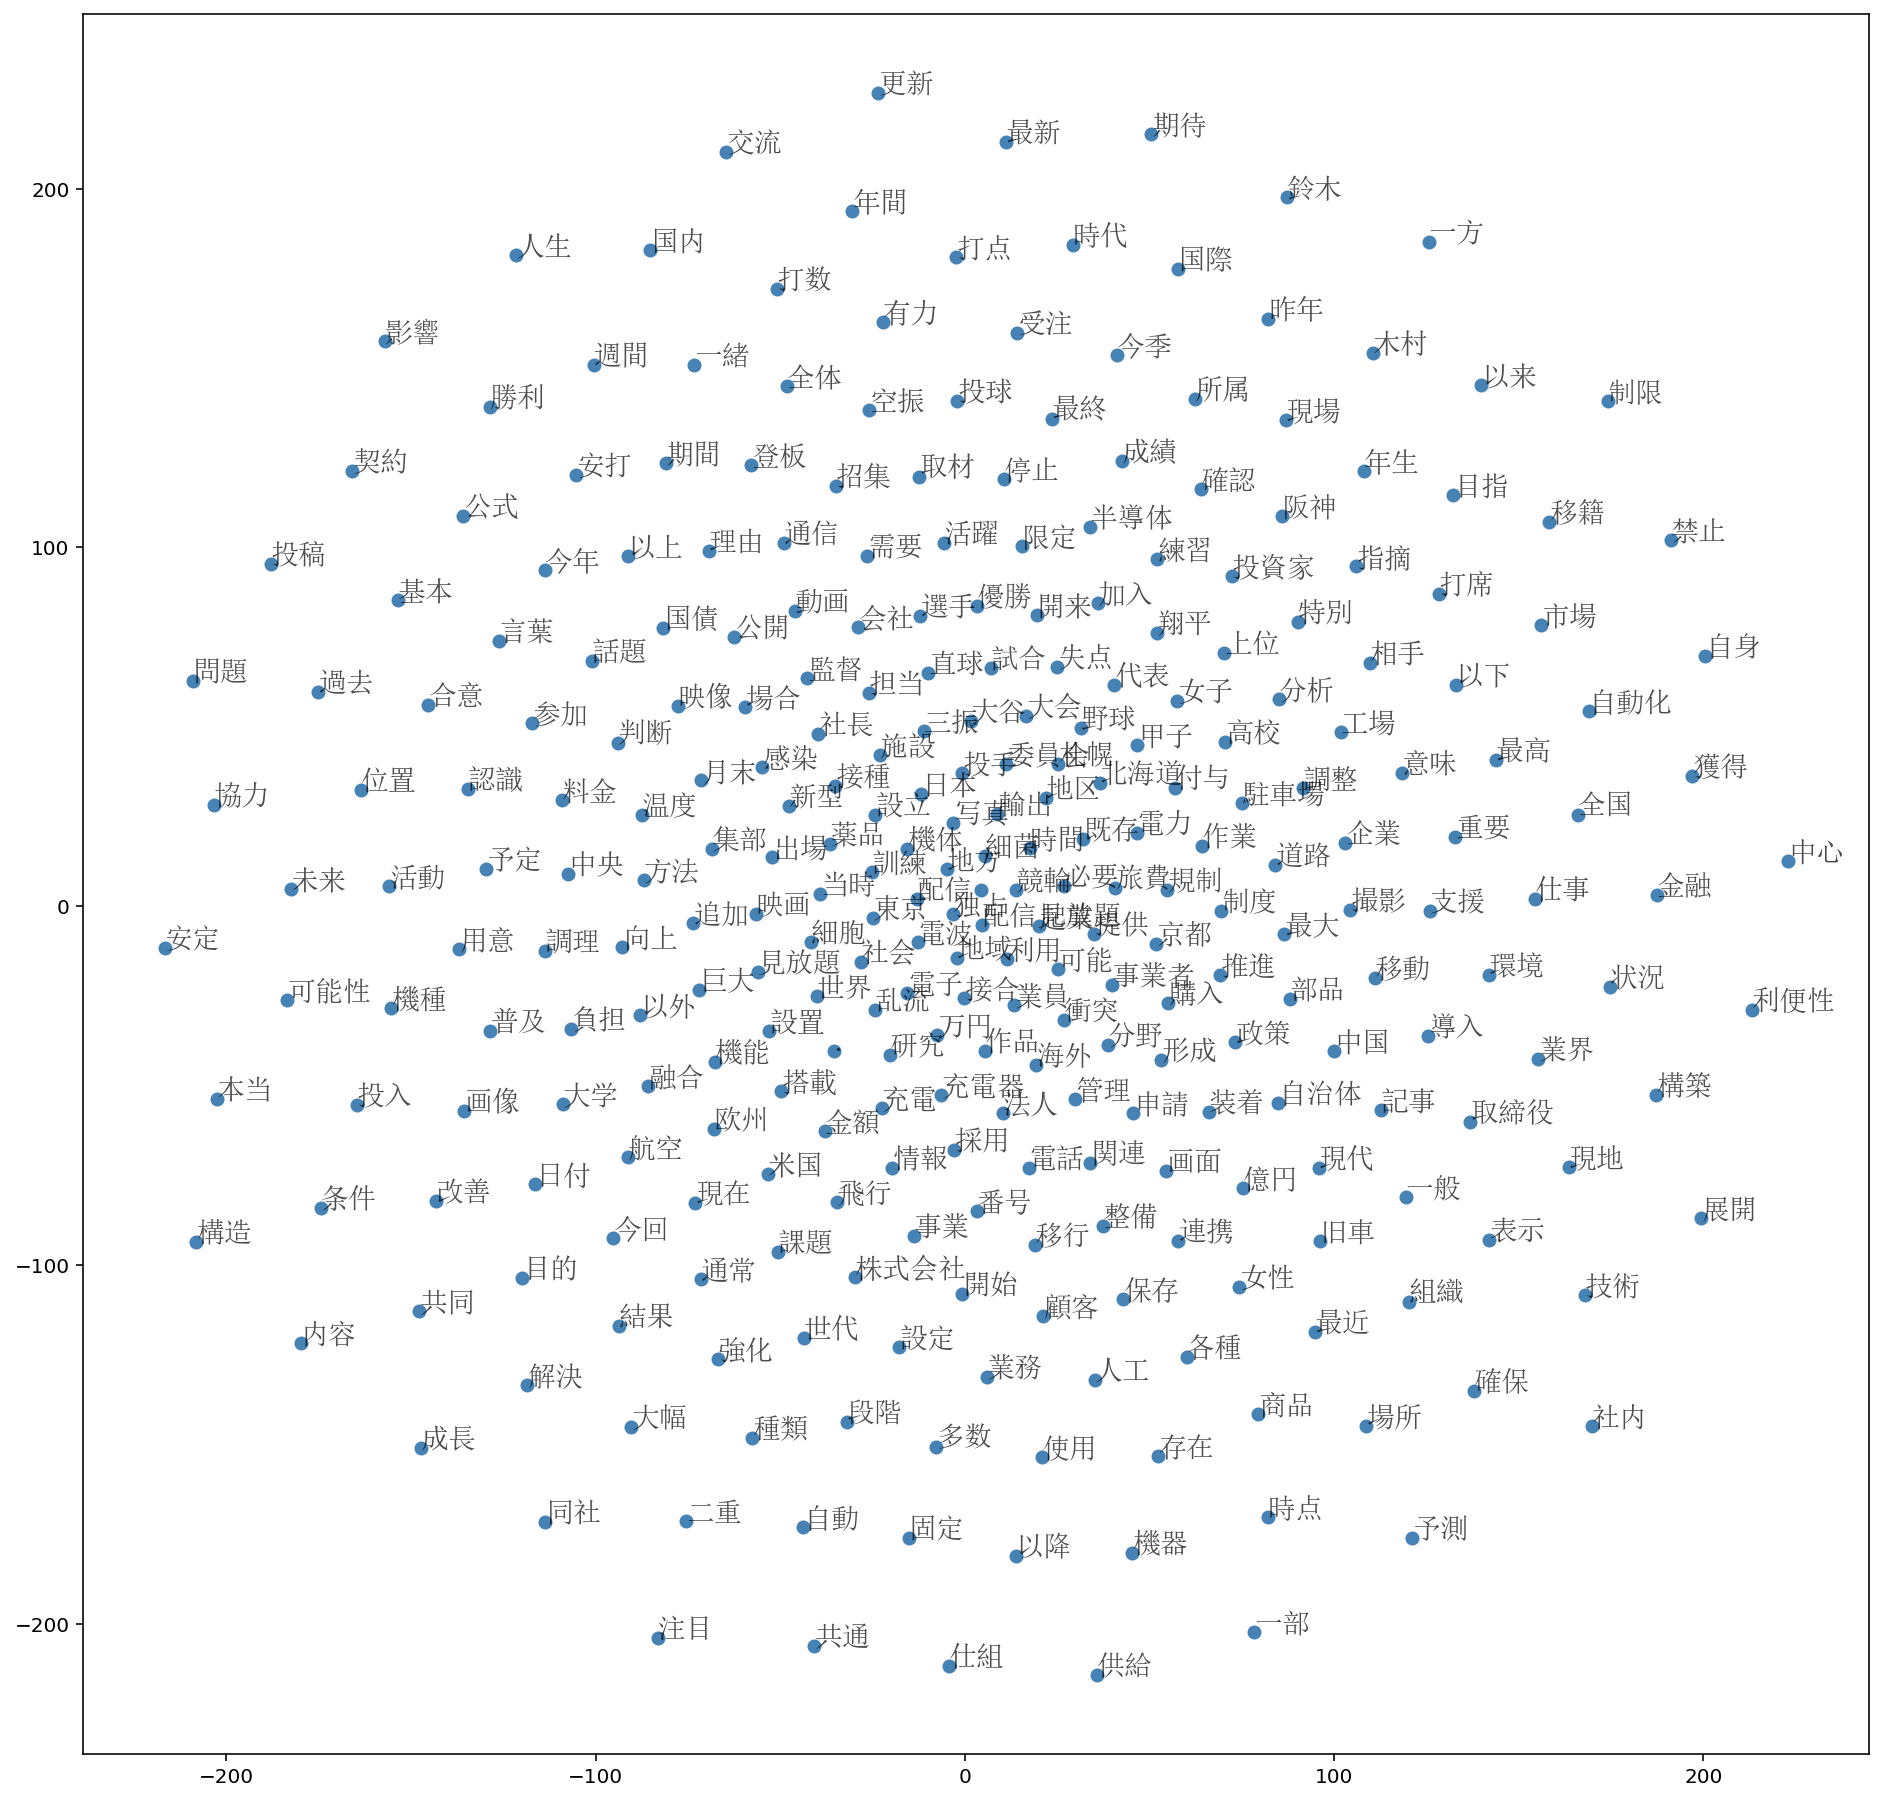

In [30]:
from matplotlib.font_manager import FontProperties
fp = FontProperties(fname=r'simsun.ttc', size=14)

fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7 , fontproperties=fp)
    

In [31]:
valid_examples, valid_similarities = cosine_similarity(model.embed, device=device)
_, closest_idxs = valid_similarities.topk(6) # topk highest similarities

valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
for ii, valid_idx in enumerate(valid_examples):
    closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
    print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))


地域 | 合理, 国税, 居住, 国家, 配車
場合 | 比較今季, 関根慎一四角, 土台, 右越, 自車
番号 | 龍谷, 画像設置, 同番, 札幌公式, 手掛
野球 | 活躍中, 輝星, 評論家, 札幌, 北海道
管理 | 自動連, 監視, 一元, 帳簿, 申請
課題 | 可能性海外, 開拓, 食数, 商品写真, 周波
購入 | 試着, 結構, 富裕最近, 家計, 富裕
会社 | 立施設, 顧客, 企業生日, 百貨店, 足度
世紀 | 佐夫武尊, 山口, 続行太田写真, 棄却, 那須
進化 | 送受, 三者, 注視, 選手写真, 本当
健太 | 勝利責任, 投手投手投手, 今宮, 展開場面, 大坂
瞬間 | 突風, 木村, 割台, 丁目本社, 風速
連盟 | 終予, 東京東京五輪, 女子, 大麻大麻, 異議
進学 | 愛美, 高校, 年商, 反省, 流通
勝因 | 指導, 辻村氏南秀樹, 香川, 高速, 取引
大山 | 甲子, 今年春先, 西勇輝, 交流, 奇妙
